# LSTM 教學筆記本
LSTM(Long Short-Term Memory)一種時間遞歸神經網RNN，論文發表於1997年。由於獨特的結構設計，LSTM適合於處理時間序列上的重要事件。

## LSTM 常被用於：
* 自然語言：LSTM擅長處理時序上的資料，因此常被用於處理語意上的任務，例如產生語句、翻譯文案等。
* 銷售預測：藉由挖掘歷史紀錄的時序特性，LSTM也被廣泛的運用在預測銷售曲線上、預測股票曲線等。

![GAN](./utils/notebook_pic/lstm.png)

## 程式語言及相關的Library
* Python 
* Numpy
* Pytorch
* matplotlib
* Pandas
* SKlearn


# 1. 導入相關的Library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.autograd import Variable

# 2. 導入 google 股價歷史資料
簡介：由Stock Predictor所收集的google股價歷史資料，我們將利用這組資料訓練LSTM預測股價。
![google_stock](./utils/notebook_pic/stock_data.png)



In [2]:
from sklearn.preprocessing import MinMaxScaler
# 導入訓練資料
INPUT_SIZE = 60
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(INPUT_SIZE, 1258):
    X_train.append(training_set_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# 導入測試資料
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - INPUT_SIZE:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(INPUT_SIZE, 80):
    X_test.append(inputs[i-INPUT_SIZE:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# 3. 定義LSTM網路

In [3]:
class LSTM(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(LSTM, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state
    
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1
lstm = LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).cuda()
print("模型結構：")
print(lstm)

模型結構：
LSTM(
  (rnn): LSTM(60, 64, num_layers=2)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


# 4. 設定訓練細節
* 訓練次數 : 預設為50
* 設定Loss function : 預設為Mean-Square-Error Loss
* 設定Optimizer : 預設為Adam

In [4]:
EPOCH = 50
optimiser = torch.optim.Adam(lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()
hidden_state = None

# 5. 進行訓練

In [5]:
for epoch in range(EPOCH):
    inputs = Variable(torch.from_numpy(X_train).float()).cuda()
    labels = Variable(torch.from_numpy(y_train).float()).cuda()

    output, hidden_state = lstm(inputs, hidden_state) 

    loss = criterion(output.view(-1), labels)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     
    optimiser.step()                                
    
    print('Epoch [{} / {}]: loss {}'.format(epoch,EPOCH,loss.item()))

Epoch [0 / 50]: loss 0.2443130761384964
Epoch [1 / 50]: loss 0.19467070698738098
Epoch [2 / 50]: loss 0.14946135878562927
Epoch [3 / 50]: loss 0.107557013630867
Epoch [4 / 50]: loss 0.06949447095394135
Epoch [5 / 50]: loss 0.03790978342294693
Epoch [6 / 50]: loss 0.017883747816085815
Epoch [7 / 50]: loss 0.016131572425365448
Epoch [8 / 50]: loss 0.03199376165866852
Epoch [9 / 50]: loss 0.04412200674414635
Epoch [10 / 50]: loss 0.04237954318523407
Epoch [11 / 50]: loss 0.03292826563119888
Epoch [12 / 50]: loss 0.023073935881257057
Epoch [13 / 50]: loss 0.016731521114706993
Epoch [14 / 50]: loss 0.014570258557796478
Epoch [15 / 50]: loss 0.015440835617482662
Epoch [16 / 50]: loss 0.01769881695508957
Epoch [17 / 50]: loss 0.019951073452830315
Epoch [18 / 50]: loss 0.02131764031946659
Epoch [19 / 50]: loss 0.021420098841190338
Epoch [20 / 50]: loss 0.0202676709741354
Epoch [21 / 50]: loss 0.01813778653740883
Epoch [22 / 50]: loss 0.015476711094379425
Epoch [23 / 50]: loss 0.012809609994292

# 5. 進行測試

In [6]:
X_train_X_test = np.concatenate((X_train, X_test),axis=0)
hidden_state = None
test_inputs = Variable(torch.from_numpy(X_train_X_test).float()).cuda()
predicted_stock_price, b = lstm(test_inputs, hidden_state)
predicted_stock_price = predicted_stock_price.cpu().data
predicted_stock_price = np.reshape(predicted_stock_price.detach().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price_all = np.concatenate((training_set[INPUT_SIZE:], real_stock_price))

# 6. 輸出測試成果

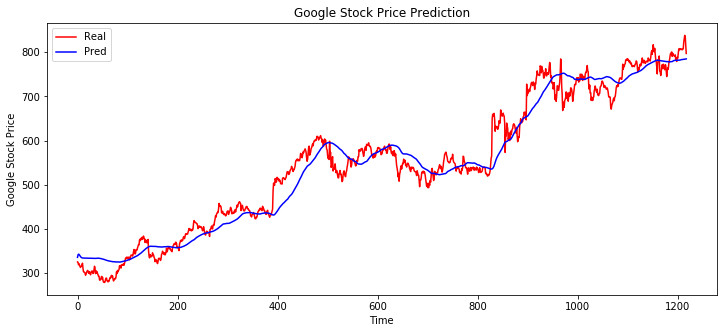

In [7]:
plt.figure(1, figsize=(12, 5))
plt.plot(real_stock_price_all, color = 'red', label = 'Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Pred')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()